# Load data

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split

f = np.load(str(Path('../data/features_(n_iterations, n_wells, n_dates, n_features).npy')))
t = np.load(str(Path('../data/targets_(n_iterations, n_wells, n_dates).npy')))

n_iterations, n_wells, n_dates, n_features = f.shape
assert t.shape == (n_iterations, n_wells, n_dates)

print(f.shape)
print(t.shape)

assert np.isnan(t).sum() == 0
print(np.isnan(f).sum() / np.prod(f.shape) * 100, '%')

(241, 10, 114, 3)
(241, 10, 114)
15.263157894736842 %


# Count NaNs

In [3]:
def get_well(f, t, well):
    well_t = t[:, well, :]
    well_f = f[:, well, :, :]
    well_f = well_f.reshape((-1, 3))
    well_t = well_t.reshape(-1)
    return well_f, well_t


def first_true_index(arr):
    for i in range(len(arr)):
        if arr[i]:
            return i
    return len(arr)


for well in range(10):
    well_f, well_t = get_well(f, t, well)
    nan_pct = np.isnan(well_f).sum() / np.prod(well_f.shape) * 100
    is_nan = (np.isnan(well_f).sum(axis=1) >= 1)
    first_not_nan = first_true_index(~is_nan) / well_f.shape[0] * 100
    print(f'well={well}: {nan_pct:.1f}% NaN; First not NaN at {first_not_nan:.3f}%')

well=0: 89.5% NaN; First not NaN at 0.328%
well=1: 0.0% NaN; First not NaN at 0.000%
well=2: 0.0% NaN; First not NaN at 0.000%
well=3: 0.0% NaN; First not NaN at 0.000%
well=4: 5.3% NaN; First not NaN at 0.022%
well=5: 5.3% NaN; First not NaN at 0.022%
well=6: 15.8% NaN; First not NaN at 0.022%
well=7: 10.5% NaN; First not NaN at 0.044%
well=8: 10.5% NaN; First not NaN at 0.044%
well=9: 15.8% NaN; First not NaN at 0.066%


# Fit linear regressions for each well ignoring time feature

In [4]:
def get_train_test(f, t, well, train_size=0.7):
    well_f, well_t = get_well(f, t, well)

    # fill NaNs
    well_f = pd.DataFrame(well_f).bfill().ffill().values

    x_train, x_test, y_train, y_test = train_test_split(well_f, well_t, train_size=train_size, random_state=0)
    return x_train, x_test, y_train, y_test

In [5]:
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [6]:
alphas = np.geomspace(1e-5, 1e5, 100)
models = [LinearRegression(), RidgeCV(alphas=alphas), LassoCV(alphas=alphas)]
scaler = StandardScaler()

models_names = [model.__class__.__name__ for model in models]
models_rmse_names = [f'{model_name} RMSE' for model_name in models_names]
models_intercept = [f'{model_name} INTERCEPT' for model_name in models_names]
models_coef = [f'{model_name} COEF' for model_name in models_names]
models_alpha = [f'{model_name} ALPHA' for model_name in models_names if model_name != 'LinearRegression']
columns = ['well', 'n_observations', 'const PRED', 'const RMSE'] + models_rmse_names + models_intercept + models_coef + models_alpha

results = pd.DataFrame(columns=columns).set_index('well')

for well in range(10):
    x_train, x_test, y_train, y_test = get_train_test(f, t, well)

    const_prediction = y_train.mean()
    const_rmse = mean_squared_error(np.full_like(y_test, const_prediction), y_test, squared=False)

    models_rmse = []
    models_intercept = []
    models_coef = []
    models_alpha = []

    for model in models:
        model.fit(scaler.fit_transform(x_train), y_train)
        rmse = mean_squared_error(model.predict(scaler.transform(x_test)), y_test, squared=False)
        models_rmse.append(rmse)
        models_intercept.append(model.intercept_)
        models_coef.append(model.coef_)
        if not isinstance(model, LinearRegression):
            models_alpha.append(model.alpha_)

    results.loc[well] = [x_train.shape[0], const_prediction, const_rmse] + models_rmse + models_intercept + models_coef + models_alpha
results

,n_observations,const PRED,const RMSE,LinearRegression RMSE,RidgeCV RMSE,LassoCV RMSE,LinearRegression INTERCEPT,RidgeCV INTERCEPT,LassoCV INTERCEPT,LinearRegression COEF,RidgeCV COEF,LassoCV COEF,RidgeCV ALPHA,LassoCV ALPHA
well,,,,,,,,,,,,,,
0,19231,0.479646,3.135950,3.115969,3.115984,3.115970,0.479646,0.479646,0.479646,"[-0.2800629543975049, 0.0, -0.18419231728510044]","[-0.2774293743551244, 0.0, -0.18252373490221618]","[-0.280001271500074, 0.0, -0.1841306101358511]",187.381742,0.000064
1,19231,6.445017,5.042689,3.612191,3.612193,3.612189,6.445017,6.445017,6.445017,"[1.7879273336872115, -0.03834291513380507, 1.9...","[1.7866781707562103, -0.038950149723245175, 1....","[1.7880342580626234, -0.038192712557793745, 1....",29.150531,0.000206
2,19231,7.668444,4.636348,3.295152,3.295120,3.295150,7.668444,7.668444,7.668444,"[1.6764694412256174, -0.14021070051599424, 1.8...","[1.675673129142826, -0.14000818531484172, 1.81...","[1.6765260332588556, -0.13994575038859974, 1.8...",23.101297,0.000260
3,19231,8.061961,4.915286,3.447397,3.447407,3.447404,8.061961,8.061961,8.061961,"[1.9446726584533585, -0.06617940801421736, 1.7...","[1.9421307308460882, -0.06673670740792703, 1.7...","[1.9447641757510326, -0.06592502499592122, 1.7...",29.150531,0.000327
4,19231,6.714263,4.658482,4.230565,4.230616,4.230566,6.714263,6.714263,6.714263,"[1.0235685697142052, 0.07053287495752406, 1.01...","[1.019888731459464, 0.06937715051509019, 1.012...","[1.0235021941566635, 0.07034750939116388, 1.01...",117.681195,0.000163
5,19231,5.439600,5.600288,5.161956,5.161990,5.161956,5.439600,5.439600,5.439600,"[1.099846824205427, 1.0536392231193126, 0.9719...","[1.0950653865958433, 1.0480597731013321, 0.968...","[1.0994204410869879, 1.053069916424008, 0.9714...",117.681195,0.000658
6,19231,3.183071,2.855584,2.816619,2.816656,2.816620,3.183071,3.183071,3.183071,"[0.18530402376109503, 0.26295568347587434, 0.2...","[0.18349155683705476, 0.25648420907513714, 0.2...","[0.1852618224282802, 0.2628503267468227, 0.210...",475.081016,0.000102
7,19231,5.701470,4.358340,3.691910,3.691892,3.691902,5.701470,5.701470,5.701470,"[1.3060784868666038, 0.4861807642301436, 1.280...","[1.3044789582255056, 0.48512360066328575, 1.27...","[1.3057032644368445, 0.48548644242684946, 1.28...",36.783798,0.000658
8,19231,6.936375,5.310070,4.272064,4.272060,4.272072,6.936375,6.936375,6.936375,"[1.6917997338857567, 0.7429585785742309, 1.778...","[1.6902991614556155, 0.7419289491929941, 1.776...","[1.6914430091424022, 0.7423254342867736, 1.777...",29.150531,0.000658


# Construct DataFrame for baseline methods

Add well number and time as features

In [7]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)


def construct_df(f, t):
    f = np.concatenate(
        [np.concatenate([f[:, well, time, :], [[well, time]] * n_iterations], axis=1) for well in range(n_wells) for time in range(n_dates)],
        axis=0, dtype=float
    )
    t = np.concatenate([t[:, well, time] for well in range(n_wells) for time in range(n_dates)], axis=0, dtype=float)
    f = pd.DataFrame(f, columns=['oilrate', 'watrate', 'gasrate', 'well', 'time']).bfill().ffill()
    f['well'] = pd.Categorical(f['well'].astype(int))
    f['time'] = pd.Categorical(f['time'].astype(int))
    return f, t


X, y = construct_df(f, t)
assert X.shape[0] == y.shape[0]
print(f'{X.shape[0]} observations')

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

274740 observations


# Constant prediction

In [8]:
const_prediction = y_train.mean()
const_rmse = rmse(np.full_like(y_test, const_prediction), y_test)
print(f'Const prediction: {const_prediction}\nConst RMSE: {const_rmse}')

Const prediction: 5.738696005867956
Const RMSE: 5.265034501830574


# Transform features

In [9]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numerical_columns = ['oilrate', 'watrate', 'gasrate']
categorical_columns = ['well', 'time']
column_transformer = ColumnTransformer([
    ('scaler', StandardScaler(), numerical_columns),
    ('ohe', OneHotEncoder(), categorical_columns)
])

X_train_transformed = column_transformer.fit_transform(X_train)
categorical_columns_ohe = column_transformer.transformers_[1][1].get_feature_names_out().tolist()
transformed_columns = numerical_columns + categorical_columns_ohe
X_train_transformed = pd.DataFrame(X_train_transformed.toarray(), columns=transformed_columns)
X_test_transformed = pd.DataFrame(column_transformer.transform(X_test).toarray(), columns=transformed_columns)

# Linear regressions

Number of features: 127
LinearRegression: RMSE=3.71272729243929


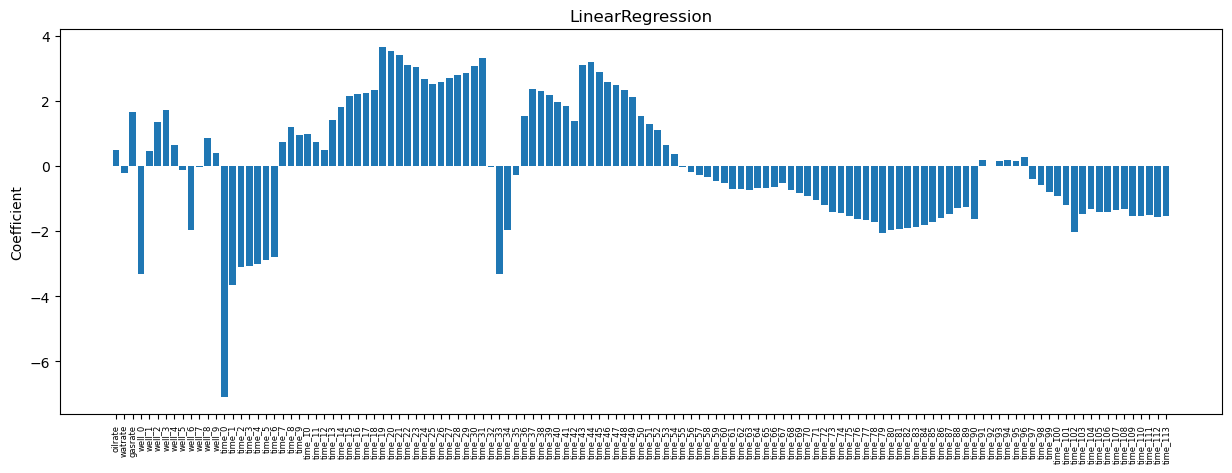

RidgeCV: RMSE=3.712706509954825
alpha=2.782559402207126


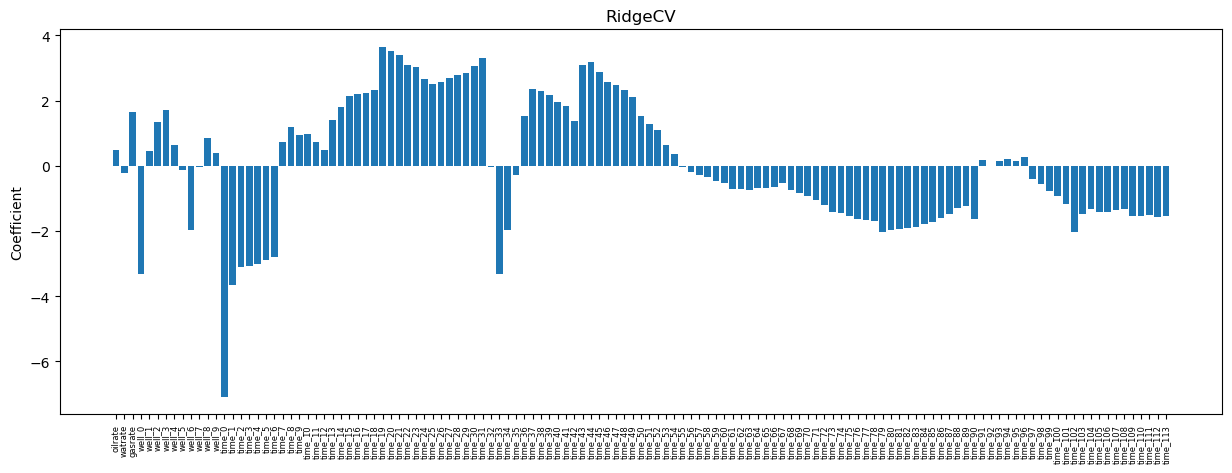

In [10]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV

alphas = np.geomspace(1e-5, 1e2, 10)
linear_models = [LinearRegression(), RidgeCV(alphas=alphas)]

print(f'Number of features: {X_test_transformed.shape[1]}')
for model in linear_models:
    model.fit(X_train_transformed, y_train)
    score = rmse(y_test, model.predict(X_test_transformed))
    model_name = model.__class__.__name__
    print(f'{model_name}: RMSE={score}')
    if not isinstance(model, LinearRegression):
        print(f'alpha={model.alpha_}')
    plt.figure(figsize=(15, 5))
    plt.bar(transformed_columns, model.coef_)
    plt.xticks(rotation=90, fontsize=6)
    plt.title(model_name)
    plt.ylabel('Coefficient')
    plt.show()


# Tree and Random Forest

In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

for model in [DecisionTreeRegressor(), RandomForestRegressor(n_estimators=10)]:
    model.fit(X_train_transformed, y_train)
    score = rmse(y_test, model.predict(X_test_transformed))
    print(f'{model.__class__.__name__} RMSE={score}')

DecisionTreeRegressor RMSE=3.6419344629594814
RandomForestRegressor RMSE=2.825516379958671


# CatBoost

In [13]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(verbose=False, cat_features=categorical_columns)
model.fit(X_train, y_train)
score = rmse(y_test, model.predict(X_test))
print(f'RMSE={score}')

D:\anaconda3\envs\invest\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


RMSE=2.4725910678717793


# TODO: